In [1]:
class IrisDataset:
    def __init__(self, images, labels):
        
        self.images = images
        self.labels = labels    
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [2]:
import os
from PIL import Image

path = "../../../data/combined_dataset"

train_labels, test_labels = [], []
train_imgs, test_imgs = [], []

train_percent = .5
for sub in os.listdir(path):
    print(sub)
    data = os.listdir(f"{path}/{sub}/iris")
    train_data = data[:int(len(data)*train_percent)]
    test_data = data[int(len(data)*train_percent):]
    for img in train_data:
        train_labels.append(int(sub))
        train_imgs.append(Image.open(f"{path}/{sub}/iris/{img}").resize((224,224)).convert("RGB")) #224,224img"))
    
    for img in test_data:
        test_labels.append(int(sub))
        test_imgs.append(Image.open(f"{path}/{sub}/iris/{img}").resize((224,224)).convert("RGB")) #224,224img"))
    

0
1
10
100
101
102
103
104
105
106
107
108
109
11
110
111
112
113
114
115
116
117
118
119
12
120
121
122
123
124
125
126
127
128
129
13
130
131
132
133
134
135
136
137
138
139
14
140
141
142
143
144
145
146
147
148
149
15
150
151
152
153
154
155
156
157
158
159
16
160
161
162
163
164
165
166
167
168
169
17
170
171
172
173
174
175
176
177
178
179
18
180
181
182
183
184
185
186
187
188
189
19
190
191
192
193
194
195
196
197
198
199
2
20
200
201
202
203
204
205
206
207
208
209
21
210
211
212
213
214
215
216
217
218
219
22
220
221
222
223
224
225
226
227
228
229
23
230
231
232
233
234
235
236
237
238
239
24
240
241
242
243
244
245
246
247
248
249
25
250
251
252
253
254
255
256
257
258
259
26
260
261
262
263
264
265
266
267
268
269
27
270
271
272
273
274
275
276
277
278
279
28
280
281
282
283
284
285
286
287
288
289
29
290
291
292
293
294
295
296
297
298
299
3
30
300
301
302
303
304
305
306
307
308
309
31
310
311
312
313
314
315
316
317
318
319
32
320
321
322
323
324
325
326
327
328
329
33


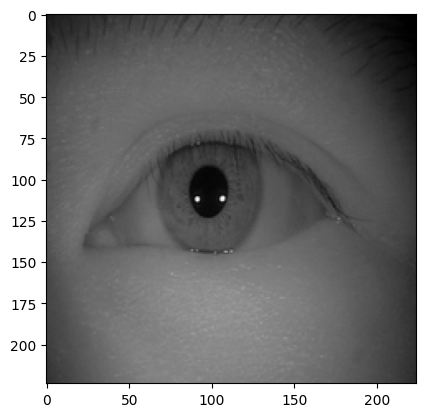

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(train_imgs[2]))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from tqdm import tqdm

# Configuration
DEVICE = "cuda"#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = 10  # Update based on your dataset

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet input size
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Preprocessing train data...")
if type(train_imgs[0]) != torch.Tensor:
    for i in range(len(train_imgs)):
        train_imgs[i] = transform(train_imgs[i])

print("Preprocessing test data...")
if type(test_imgs[0]) != torch.Tensor:
    for i in range(len(test_imgs)):
        test_imgs[i] = transform(test_imgs[i])

# Load dataset
train_dataset = IrisDataset(train_imgs, train_labels)
test_dataset = IrisDataset(test_imgs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(len(train_dataset.labels))

# Load EfficientNet model
model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(in_features=1408, out_features=500)
model = model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Preprocessing train data...
Preprocessing test data...
5000


In [5]:
# train_dataset[0][0].shape
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [6]:

# Training and validation function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy


def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

In [7]:
# model.load_state_dict(torch.load("efficientnet_iris_10.pth", weights_only=True))
# model = model.to(DEVICE)

# val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, DEVICE)
# val_loss, val_acc


In [8]:

loss_history = []
accuracy_history = []

best_model = None
best_acc = 0

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, DEVICE)
    loss_history.append(val_loss)
    accuracy_history.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model.state_dict() 
    
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'efficientnet_iris_{epoch}.pth')

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

torch.save(best_model, "efficientnet_iris_best_epoch.pth")
# Save the trained model
torch.save(model.state_dict(), 'efficientnet_iris.pth')
print("Model saved to efficientnet_iris.pth")


loss_history = np.array(loss_history)
accuracy_history = np.array(accuracy_history)

np.save("loss_history.npy", loss_history)
np.save("accuracy_history.npy", accuracy_history)

Epoch 1/25


Train Loss: 4.8033, Train Accuracy: 15.00%
Validation Loss: 3.0874, Validation Accuracy: 31.80%
Epoch 2/25


Train Loss: 1.0320, Train Accuracy: 78.30%
Validation Loss: 0.8753, Validation Accuracy: 78.88%
Epoch 3/25


Train Loss: 0.1746, Train Accuracy: 97.46%
Validation Loss: 0.5877, Validation Accuracy: 85.80%
Epoch 4/25


Train Loss: 0.0681, Train Accuracy: 99.10%
Validation Loss: 0.3627, Validation Accuracy: 90.78%
Epoch 5/25


Train Loss: 0.0527, Train Accuracy: 99.16%
Validation Loss: 0.3902, Validation Accuracy: 89.94%
Epoch 6/25


Train Loss: 0.0624, Train Accuracy: 99.04%
Validation Loss: 0.5347, Validation Accuracy: 87.26%
Epoch 7/25


Train Loss: 0.1244, Train Accuracy: 97.38%
Validation Loss: 0.6290, Validation Accuracy: 84.08%
Epoch 8/25


Train Loss: 0.0463, Train Accuracy: 99.18%
Validation Loss: 0.3465, Validation Accuracy: 90.64%
Epoch 9/25


Train Loss: 0.0484, Train Accuracy: 99.08%
Validation Loss: 0.4598, Validation Accuracy: 88.60%
Epoch 10/25


Train Loss: 0.0557, Train Accuracy: 98.62%
Validation Loss: 0.4707, Validation Accuracy: 88.16%
Epoch 11/25


Train Loss: 0.0724, Train Accuracy: 98.40%
Validation Loss: 0.4897, Validation Accuracy: 87.28%
Epoch 12/25


Train Loss: 0.0711, Train Accuracy: 98.44%
Validation Loss: 0.6090, Validation Accuracy: 84.40%
Epoch 13/25


Train Loss: 0.0497, Train Accuracy: 98.94%
Validation Loss: 0.4180, Validation Accuracy: 89.38%
Epoch 14/25


Train Loss: 0.0285, Train Accuracy: 99.36%
Validation Loss: 0.3028, Validation Accuracy: 92.40%
Epoch 15/25


Train Loss: 0.0389, Train Accuracy: 99.10%
Validation Loss: 0.5355, Validation Accuracy: 86.28%
Epoch 16/25


Train Loss: 0.0376, Train Accuracy: 99.14%
Validation Loss: 0.3523, Validation Accuracy: 89.86%
Epoch 17/25


Train Loss: 0.0613, Train Accuracy: 98.54%
Validation Loss: 0.2876, Validation Accuracy: 92.20%
Epoch 18/25


Train Loss: 0.0272, Train Accuracy: 99.56%
Validation Loss: 0.2964, Validation Accuracy: 91.80%
Epoch 19/25


Train Loss: 0.0055, Train Accuracy: 99.96%
Validation Loss: 0.2053, Validation Accuracy: 94.68%
Epoch 20/25


Train Loss: 0.0017, Train Accuracy: 99.98%
Validation Loss: 0.1824, Validation Accuracy: 95.42%
Epoch 21/25


Train Loss: 0.0039, Train Accuracy: 99.94%
Validation Loss: 0.1951, Validation Accuracy: 94.76%
Epoch 22/25


Train Loss: 0.0956, Train Accuracy: 97.38%
Validation Loss: 0.7849, Validation Accuracy: 81.74%
Epoch 23/25


Train Loss: 0.0717, Train Accuracy: 98.14%
Validation Loss: 0.6856, Validation Accuracy: 82.56%
Epoch 24/25


Train Loss: 0.0425, Train Accuracy: 98.92%
Validation Loss: 0.4149, Validation Accuracy: 89.48%
Epoch 25/25


Train Loss: 0.0627, Train Accuracy: 98.54%
Validation Loss: 0.4614, Validation Accuracy: 88.90%
Model saved to efficientnet_iris.pth


In [9]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_acc


95.42

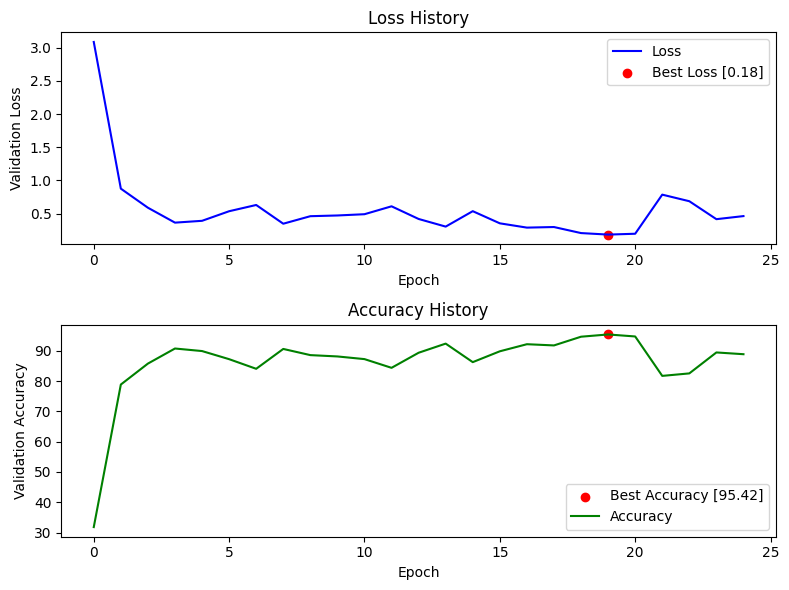

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
loss_history = np.load("loss_history.npy")
accuracy_history = np.load("accuracy_history.npy")

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# Plot loss history
ax[0].plot(loss_history, label="Loss", color="blue")
ax[0].set_title("Loss History")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Validation Loss")
idx_min = np.argmin(loss_history)
ax[0].scatter(idx_min, loss_history[idx_min], color="red", label=f"Best Loss [{loss_history[idx_min]:.2f}]")

ax[0].legend()

idx_max = np.argmax(accuracy_history)
ax[1].scatter(idx_max, accuracy_history[idx_max], color="red", label=f"Best Accuracy [{best_acc:.2f}]")
# Plot accuracy history
ax[1].plot(accuracy_history, label="Accuracy", color="green")
ax[1].set_title("Accuracy History")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Accuracy")
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


fig.savefig("../../figures/efficientnet_iris_acc_loss.svg", format="svg")

### Use best model to extract features from test set

In [11]:
model.load_state_dict(torch.load("efficientnet_iris_best_epoch.pth", weights_only=True))
model.classifier = nn.Identity()

model = model.to(DEVICE)

In [12]:
# Extract features
def extract_features(loader, model, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, label in tqdm(loader, desc="Extracting features", leave=False):
            images = images.to(device)
            features.append(model(images).cpu())
            labels.append(label)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels

In [13]:
feats, labels = extract_features(val_loader, model, "cuda")

In [14]:
type(feats[0].numpy()), type(labels[0].numpy()), labels[0].numpy().item()

(numpy.ndarray, numpy.ndarray, 0)

In [15]:
sample = 0
last_label = 0
for feat, lab in zip(feats, labels):
    feat = feat.numpy()
    lab = lab.numpy().item()
    
    if lab != last_label:
        sample = 0
        last_label = lab
    
    np.save(f"features/sub{lab}_{sample}.npy", feat)
    sample += 1